# SMAI Assignment - 4

## $\color{gold}{\text{Mini-Project: Age Prediction}}$

In [42]:
# Helpful preamble commands and imports for Jupyter notebooks 

# reload notebook automatically after changes to source python files
%load_ext autoreload
%autoreload 2

# standard libraries
from pathlib import Path
import json
from glob import glob
from os.path import join
from pathlib import Path
from tqdm import tqdm

# scientific computing
import math
import numpy as np
import pandas as pd
from PIL import Image

# visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# setting random seed for reproducibility
RANDOM_SEED = 24
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

KAGGLE = False
if KAGGLE:
    DATA_PATH = Path('/kaggle/input/smai-24-age-prediction/content/faces_dataset/')
else:
    DATA_PATH = Path('data/')

train_path = DATA_PATH / 'train_aug_4'
train_ann_path = DATA_PATH / 'train_aug_4.csv'
test_path = DATA_PATH / 'test'
test_ann_path = DATA_PATH / 'submission.csv'

In [44]:
class AgeDataset(torch.utils.data.Dataset):

    def __init__(self, data_path, annot_path, train=True):
        super(AgeDataset, self).__init__()

        self.annot_path = annot_path
        self.data_path = data_path
        self.train = train
        
        self.ann = pd.read_csv(annot_path)
        self.files = self.ann['file_id']
        if train:
            self.ages = self.ann['age']
        self.transform = self._transform(224)

    @staticmethod    
    def _convert_image_to_rgb(image):
        return image.convert("RGB")

    def _transform(self, n_px):
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        return Compose([
            Resize(n_px),
            self._convert_image_to_rgb,
            ToTensor(),
            Normalize(mean, std),
        ])

    def read_img(self, file_name):
        im_path = join(self.data_path,file_name)   
        img = Image.open(im_path)
        img = self.transform(img)
        return img

    def __getitem__(self, index):
        file_name = self.files[index]
        img = self.read_img(file_name)
        if self.train:
            age = self.ages[index]    
            return img, age
        else:
            return img

    def __len__(self):
        return len(self.files)

train_dataset = AgeDataset(train_path, train_ann_path, train=True)
test_dataset = AgeDataset(test_path, test_ann_path, train=False)

In [45]:
from torch.utils.data import random_split

val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# printing the number of training and test examples
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")

Number of training examples: 27526
Number of validation examples: 3058
Number of test examples: 1950


In [46]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights, resnet34, ResNet34_Weights

class KronosNet(nn.Module):
    def __init__(self, num_classes=1, freeze_layers=-1, use_batchnorm=False):
        super(KronosNet, self).__init__()
        
        # loading resnet50 model and freezing its parameters
        # resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        # resnet = resnet34(weights=ResNet34_Weights.DEFAULT)
        # resnet = resnet18()
            
        if freeze_layers > 0:
            for idx, child in enumerate(resnet.children()):
                if idx < freeze_layers:
                    for param in child.parameters():
                        param.requires_grad = False
                else:
                    break
        else:
            for param in resnet.parameters():
                param.requires_grad = True
            
        # changing the last layer to output num_classes
        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Linear(num_ftrs, num_classes)
        
        if use_batchnorm:
            resnet = self.add_batchnorm(resnet)
        
        self.resnet = resnet
        
    def forward(self, x):
        return self.resnet(x)
    
    def add_batchnorm(self, model):
        # Add batch normalization to each convolutional layer
        for child_name, child in model.named_children():
            if isinstance(child, nn.Conv2d):
                setattr(model, child_name, nn.Sequential(child, nn.BatchNorm2d(child.out_channels)))
            else:
                self.add_batchnorm(child)
        return model

# sanity check on the model
num_classes = 1
test_knet = KronosNet(num_classes)
img = torch.randn(5, 3, 224, 224)
pred = test_knet(img)
print(f"Input shape: {img.shape}")
print(f"Pred shape: {pred.shape}")

Input shape: torch.Size([5, 3, 224, 224])
Pred shape: torch.Size([5, 1])


In [47]:
import torch.optim as optim

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    mean_abs_error = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        mean_abs_error += torch.abs(outputs - targets.unsqueeze(1).float()).mean().item()
    
    train_loss /= len(train_loader)
    mean_abs_error /= len(train_loader)
    
    return train_loss, mean_abs_error
        
def evaluate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    mean_abs_error = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1).float())
            
            val_loss += loss.item()
            mean_abs_error += torch.abs(outputs - targets.unsqueeze(1).float()).mean().item()
    
    val_loss /= len(val_loader)
    mean_abs_error /= len(val_loader)
    
    return val_loss, mean_abs_error

def run_experiment(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, save_path='model.pth'):
    train_losses = []
    val_losses = []
    train_errors = []
    val_errors = []
    
    best_val_error = float('inf')
    
    for epoch in range(num_epochs):
        train_loss, train_error = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_error = evaluate_epoch(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_errors.append(train_error)
        val_errors.append(val_error)
        
        print(f"Epoch {epoch+1}/{num_epochs} => Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Error: {train_error:.4f}, ValError: {val_error:.4f}")

        if val_error < best_val_error:
            best_val_error = val_error
            torch.save(model.state_dict(), save_path)
            print(f"🦸 Best model at epoch {epoch+1} saved to {save_path}")
        
    # return train_losses, val_losses, train_errors, val_errors as a dictionary
    results_dict = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_errors': train_errors,
        'val_errors': val_errors
    }
    return results_dict 

In [48]:
def plot_results(results_dict, title):
    train_losses = results_dict['train_losses']
    val_losses = results_dict['val_losses']
    train_errors = results_dict['train_errors']
    val_errors = results_dict['val_errors']
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(train_losses, label='Train Loss')
    ax[0].plot(val_losses, label='Val Loss')
    ax[0].set_title('Loss')
    ax[0].legend()
    
    ax[1].plot(train_errors, label='Train Error')
    ax[1].plot(val_errors, label='Val Error')
    ax[1].set_title('Mean Absolute Error')
    ax[1].legend()
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

# defining the model, loss function, and optimizer
num_classes = 1
freeze_layers = 6
knet = KronosNet(num_classes, freeze_layers, use_batchnorm=False).to(device)

SAVE_PATH = 'kronosnet-res-regr.pth'
LOAD_PRETRAINED = False
if LOAD_PRETRAINED:
    print("Loading pretrained model")
    knet.load_state_dict(torch.load(SAVE_PATH))

# criterion = nn.L1Loss()
# criterion = nn.MSELoss().to(device)

# use L1SmoothLoss
criterion = nn.SmoothL1Loss().to(device)

lr = 0.002
weight_decay = 0.01
optimizer = optim.AdamW(knet.parameters(), lr=lr, weight_decay=weight_decay)

# defining the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

# running the experiment
results_dict = run_experiment(knet, train_loader, val_loader, criterion, optimizer, device, num_epochs=20, save_path=SAVE_PATH)

Training on device: cuda
Epoch 1/20 => Train Loss: 7.4180, Val Loss: 6.6104, Train Error: 7.8977, ValError: 7.0893
🦸 Best model at epoch 1 saved to kronosnet-res-regr.pth
Epoch 2/20 => Train Loss: 5.2606, Val Loss: 5.7543, Train Error: 5.7343, ValError: 6.2265
🦸 Best model at epoch 2 saved to kronosnet-res-regr.pth
Epoch 3/20 => Train Loss: 4.6129, Val Loss: 5.1283, Train Error: 5.0837, ValError: 5.5989
🦸 Best model at epoch 3 saved to kronosnet-res-regr.pth
Epoch 4/20 => Train Loss: 4.0706, Val Loss: 5.6422, Train Error: 4.5371, ValError: 6.1106
Epoch 5/20 => Train Loss: 3.6595, Val Loss: 4.7765, Train Error: 4.1237, ValError: 5.2464
🦸 Best model at epoch 5 saved to kronosnet-res-regr.pth
Epoch 6/20 => Train Loss: 3.2469, Val Loss: 4.7750, Train Error: 3.7071, ValError: 5.2432
🦸 Best model at epoch 6 saved to kronosnet-res-regr.pth
Epoch 7/20 => Train Loss: 2.8944, Val Loss: 4.7850, Train Error: 3.3511, ValError: 5.2502
Epoch 8/20 => Train Loss: 2.6900, Val Loss: 4.7638, Train Error: 

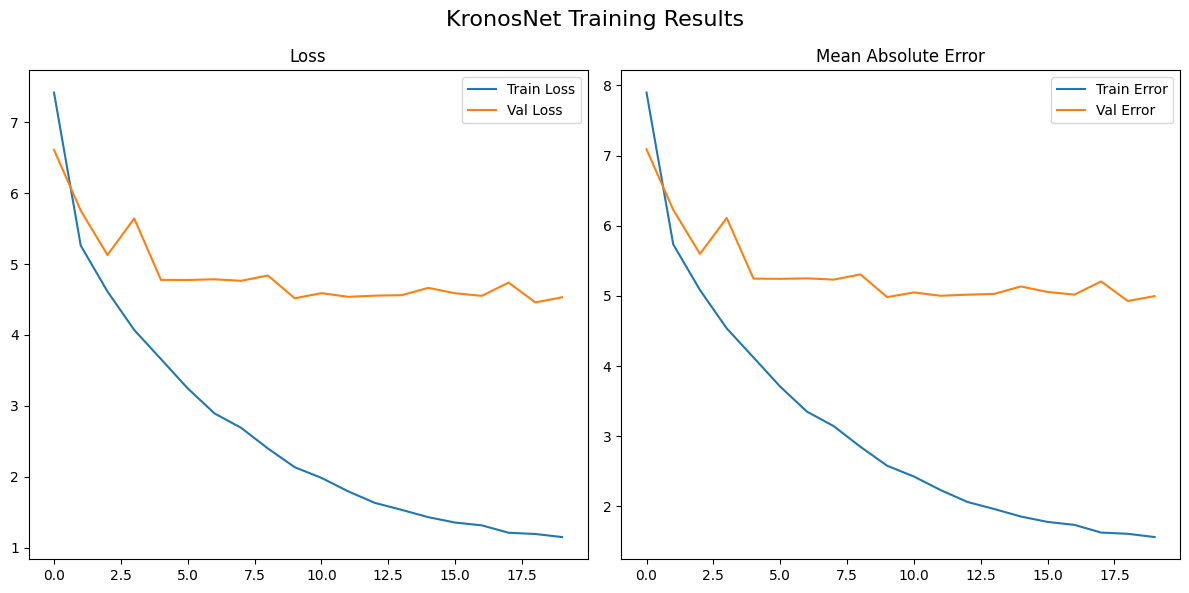

In [50]:
plot_results(results_dict, 'KronosNet Training Results')

In [51]:
@torch.no_grad
def predict(loader, model):
    model.eval()
    predictions = []

    for img in tqdm(loader):
        img = img.to(device)

        pred = model(img)
        # converting predictions to ints
        pred = pred.cpu().numpy()
        predictions.extend(pred.flatten().tolist())

    return predictions

# loading the best model
knet.load_state_dict(torch.load(SAVE_PATH))
knet.to(device)

preds = predict(test_loader, knet)
submit = pd.read_csv(test_ann_path)
submit["age"] = preds
submit.head()

submit.to_csv("baseline.csv", index=False)

# sanity check on the submitted baseline file
print(f"Number of test examples: {len(submit)}")


100%|██████████| 31/31 [00:03<00:00,  8.48it/s]

Number of test examples: 1950
